In [38]:
from os import listdir
from os.path import isfile, join, exists
from PIL import Image
import torch
import torchvision.utils as vutils
import torchvision.transforms as tranforms
import matplotlib.pyplot as plt

from mfcc import MFCC
from network import get_network
from utils import voice2face, npy2face, getNpy, getMultipleNpy
from facenet_pytorch import InceptionResnetV1
import numpy as np
import pandas as pd
from tqdm import tqdm
from network import VoiceEmbedNet, Generator
import string

In [61]:
NETWORKS_PARAMETERS = {
    # VOICE EMBEDDING NETWORK (e)
    'e': {
        'network': VoiceEmbedNet,
        'input_channel': 64,
        'channels': [256, 384, 576, 864],
        'output_channel': 64, # the embedding dimension
        'model_path': 'pretrained_models/voice_embedding.pth',
    },
    # GENERATOR (g)
    'g': {
        'network': Generator,
        'input_channel': 64,
        'channels': [1024, 512, 256, 128, 64], # channels for deconvolutional layers
        'output_channel': 3, # images with RGB channels
        # 'model_path': 'training_models/generator.pth',
        'model_path': 'pretrained_models/generator_100.pth',
    },
    'GPU': True}

In [62]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [63]:
e_net, _ = get_network('e', NETWORKS_PARAMETERS, train=False)
g_net, _ = get_network('g', NETWORKS_PARAMETERS, train=False)

# ids_list = [10190, 10167, 10182, 10306, 10498]

# old_list = [10090, 10086, 10116, 10303, 10203, 10242, 10096, 10088]

In [21]:
model = InceptionResnetV1(pretrained='vggface2').eval().to(device)


In [22]:
transform = tranforms.Resize(160)

In [166]:
def parse_metafile(meta_file):
    with open(meta_file, 'r') as f:
        lines = f.readlines()[1:]
    celeb_ids = {}
    for line in lines:
        ID, name, gender, nation, dev = line.rstrip().split('\t')
        celeb_ids[ID] = (name, gender, nation, dev)
    return celeb_ids

def load_face(face_path):
    face_data = Image.open(face_path).convert('RGB').resize([64, 64])
    face_data = np.transpose(np.array(face_data), (2, 0, 1))
    face_data = ((face_data - 127.5) / 127.5).astype('float32')
    return face_data


def load_test_face(face_path):
    face_data = Image.open(face_path).convert('RGB').resize([160, 160])
    face_data = np.transpose(np.array(face_data), (2, 0, 1))
    face_data = ((face_data - 127.5) / 127.5).astype('float32')
    return face_data

celeb_map = parse_metafile('data/vox1_meta.csv')
cropped_face_root = 'data/cropped_faces/'
face_root = 'data/VGG_ALL_FRONTAL/'

def get_face(celeb_id, path):
    name = celeb_map['id'+(str(celeb_id))][0]
    face_folder = path + name
    if not exists(face_folder):
        return None
    onlyfiles = [f for f in listdir(face_folder) if f.endswith('jpg') and isfile(join(face_folder, f))]
    face = load_test_face(join(face_folder, onlyfiles[12]))
    return torch.Tensor(face).to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


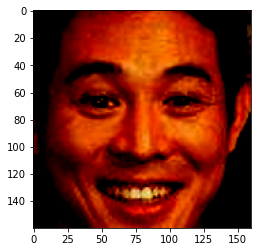

In [169]:
temp = get_face(10498, cropped_face_root).cpu().detach().numpy()
plt.imshow(temp.transpose((1,2,0)))

In [74]:
embs = []
targets = []
id_list = []
for ids in tqdm(celeb_map.keys(), total=len(celeb_map.keys())):
   
    name, gender, nation, dev = celeb_map[ids]
    id_num = int(ids[2:])
    target_path = get_face(id_num, face_root)
    if target_path is None:
        continue
    id_list.append(ids)
    face_target = transform(target_path).reshape((1, 3, 160, 160))
    arr = getNpy(id_num)
    face_image = npy2face(e_net, g_net, arr, NETWORKS_PARAMETERS['GPU'])
    face = transform(face_image)
    emb = model(face)
    
    emb_target = model(face_target)

    targets.append(emb_target.detach().cpu())
    embs.append(emb.detach().cpu())
    torch.cuda.empty_cache()
    del face_target
    del face
    del face_image
    del emb
    del emb_target


100%|██████████| 1251/1251 [02:22<00:00,  8.80it/s]


In [27]:
n = len(embs)
sims = [(e1 - e2).norm().item() for (e1, e2) in zip(targets, embs)]
dists = [[(e1 - e2).norm().item() for e2 in embs] for e1 in targets]
df = pd.DataFrame(dists, columns=id_list, index=id_list)
correct_rate = (df>sims).sum().sum()/(n*(n - 1))
print('correct rate: ', correct_rate)
print('average distance aligned: ', np.mean(sims))
print('average distance misaligned: ', (df.sum().sum() - np.sum(sims))/(n*(n-1)))


correct rate:  0.8841463251967454
average distance aligned:  1.1351809354704254
average distance misaligned:  1.3960006647502659


In [75]:
n = len(embs)
sims1 = [(e1 - e2).norm().item() for (e1, e2) in zip(targets, embs)]
dists1 = [[(e1 - e2).norm().item() for e2 in embs] for e1 in targets]
df1 = pd.DataFrame(dists1, columns=id_list, index=id_list)

In [72]:
## stratify:
id_stra = []
test_letter = set(string.ascii_uppercase[:5])
sims_stra = []
for i in range(len(id_list)):
    ids = id_list[i]
    name, gender, nation, dev = celeb_map[ids]
    if gender != 'm':
        sims_stra.append(sims[i])
        id_stra.append(ids)

In [73]:
df_stra = df.loc[id_stra, id_stra]
s = len(sims_stra)
correct_rate = (df_stra>sims_stra).sum().sum()/(s*(s - 1))
print('correct rate: ', correct_rate)
print('average distance aligned: ', np.mean(sims_stra))
print('average distance misaligned: ', (df_stra.sum().sum() - np.sum(sims_stra))/(s*(s-1)))

correct rate:  0.8694330225285226
average distance aligned:  1.1173540327070435
average distance misaligned:  1.3759767332653532


In [85]:
id_stra = []
test_letter = set(string.ascii_uppercase[:5])
sims_stra = []
for i in range(len(id_list)):
    ids = id_list[i]
    name, gender, nation, dev = celeb_map[ids]
    if name[0] in test_letter and gender != 'm':
        sims_stra.append(sims1[i])
        id_stra.append(ids)

In [86]:
df_stra = df1.loc[id_stra, id_stra]
s = len(sims_stra)
correct_rate = (df_stra>sims_stra).sum().sum()/(s*(s - 1))
print('correct rate: ', correct_rate)
print('average distance aligned: ', np.mean(sims_stra))
print('average distance misaligned: ', (df_stra.sum().sum() - np.sum(sims_stra))/(s*(s-1)))

correct rate:  0.6424473975636766
average distance aligned:  1.3355389045322457
average distance misaligned:  1.393775611909917


In [87]:
len(sims_stra)

301

In [ ]:
119 301

In [89]:
fm = 119/301
mm = 1 - fm
mt = 0.615111407929087
ft = 0.572069505768409
print(fm*ft + mm*mt)

0.5980948419585863
